In [1]:
! pip install implicit

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2020-12-08 18:56:59--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  6.73MB/s    in 0.8s    

2020-12-08 18:57:00 (6.73 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [3]:
!unzip -q ml-1m.zip -d .

In [4]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import implicit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from tqdm import tqdm, trange
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data

## Загрузка

Я выбрала датасет movielens. Для этого было несколько причин:
1. Он используется в статье Neural Collaborative Filtering (причем именно та же версия, что была у нас в домашке)
2. Мы уже работали с ним в первой домашке :)

Чтобы использовать датасет в качестве implicit данных будем назначать 1 паре (user, item), если пользователь хоть как-то оценил фильм, и 0 иначе. Именно так сделали в статье Neural Collaborative Filtering.

In [6]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                      usecols=['user_id', 'movie_id', 'rating', 'timestamp'], 
                      engine='python')

In [7]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python')

Заведем внутренние айдишники для пользователей и фильмов.

In [8]:
all_users = np.unique(ratings["user_id"])
user2idx = dict(zip(all_users, range(len(all_users))))
idx2user = dict(zip(range(len(all_users)), all_users))

In [9]:
all_movies = np.unique(ratings["movie_id"])
movie2idx = dict(zip(all_movies, range(len(all_movies))))
idx2movie = dict(zip(range(len(all_movies)), all_movies))

In [10]:
ratings.sort_values(by=['user_id', 'timestamp'], inplace=True)

In [11]:
test = ratings.groupby('user_id').movie_id.apply(lambda x: list(x)[-1]).reset_index().to_numpy()

In [12]:
all_pairs_set = set([tuple([user, movie]) for user, movie in zip(ratings["user_id"], ratings["movie_id"])])

In [13]:
test_pairs_set = set([tuple(pair) for pair in test])

In [14]:
train_pairs_set = all_pairs_set - test_pairs_set

In [15]:
train = np.array([list(pair) for pair in train_pairs_set])

In [16]:
users = [user2idx[user] for user in train[:, 0]]
movies = [movie2idx[item] for item in train[:, 1]]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
item_user_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

In [17]:
test = dict(test)

In [18]:
class Recommender:
    def __init__(self, user_item_csr, user2idx, idx2user, item2idx, idx2item):
        self.user2idx = user2idx
        self.idx2user = idx2user
        self.item2idx = item2idx
        self.idx2item = idx2item
        self.user_item_csr = user_item_csr

    def _get_history(self, user):
        user_idx = self.user2idx[user]
        return [int(self.idx2item[it_id]) for it_id in self.user_item_csr.getrow(user_idx).nonzero()[1]]

    def get_history(self, user, movie_dataset):
        movies = self._get_history(user)
        return movie_dataset[movie_dataset.movie_id.isin(movies)]
    
    def _recommend(self, user, model, k=10):
        with torch.no_grad():
            user_idx = self.user2idx[user]
            if isinstance(model, BPR):
                recommends = model.get_recommend(user_idx, self.user_item_csr, k)
            else:
                rating = self.user_item_csr.getrow(user_idx)
                not_known_items = np.array(list(set(
                    range(self.user_item_csr.shape[1])) - set(rating.nonzero()[1])))
                recommends = model.get_recommend(user_idx, not_known_items, k)
            recommends = [self.idx2item[idx] for idx in recommends]
        return recommends
    
    def recommend(self, user, model, movie_dataset, k=10):
        recommends = self._recommend(user, model, k)
        return movie_dataset[movie_dataset.movie_id.isin(recommends)]
    
    def _get_similars(self, item, model, k=10):
        with torch.no_grad():
            item_idx = self.item2idx[item]
            similars = model.get_similars(item_idx, k)
            similars = [self.idx2item[idx] for idx in similars]
        return similars
    
    def get_similars(self, item_idx, model, movie_dataset, k=10):
        similars = self._get_similars(item_idx, model, k)
        return movie_dataset[movie_dataset.movie_id.isin(similars)]
    
    def metrics(self, model, test, k=10):
        hr = []
        ndcg = []
        for user, user_idx in tqdm(self.user2idx.items()):
            rating = self.user_item_csr.getrow(user_idx)
            not_known_items = np.array(list(set(
                range(self.user_item_csr.shape[1])) - set(rating.nonzero()[1])))
            not_known_part = np.random.choice(not_known_items, 
                                              size=99, replace=False)
            # Calc score
            real_item_idx = self.item2idx[test[user]]
            pairs = zip([user_idx] * 100, 
                        np.concatenate([np.array([real_item_idx]), not_known_part]))
            pairs = torch.Tensor(list(pairs)).long().to(device)
            with torch.no_grad():
                scores = np.array(model.score_calc(pairs)).reshape((-1, ))

            # NDCG
            real = np.zeros(100)
            real[0] = 1
            ndcg.append(ndcg_score([real], [scores], k=k))

            # HR
            ranges = scores.argsort()[::-1]
            hr.append(int(0 in ranges[:k]))
        print()
        print(f'NDCG@{k} = {np.mean(ndcg):.4f}, HR@{k} = {np.mean(hr)}')

In [19]:
num_users, num_items = user_item_csr.shape
rec = Recommender(user_item_csr, user2idx, idx2user, movie2idx, idx2movie)

# BPR

In [102]:
class BPR:
    def __init__(self, factors=63, iterations=500, lr=1e-3, reg=1e-2):
        self.model = implicit.bpr.BayesianPersonalizedRanking(factors=factors, 
                                                              iterations=iterations, 
                                                              learning_rate=lr, 
                                                              regularization=reg)

    def fit(self, item_user_csr):
        self.model.fit(item_user_csr)

    def get_similars(self, item_idx,  k):
        similars = self.model.similar_items(item_idx, N=k)
        similars = [pair[0] for pair in similars]
        return similars
    
    def get_recommend(self, user_idx, user_item_csr, k):
        recommends = self.model.recommend(user_idx, user_item_csr, N=k)
        recommends = [pair[0] for pair in recommends]
        return recommends
    
    def score_calc(self, pairs):
        pairs = np.array(pairs.cpu()).astype('int')
        user_emb = self.model.user_factors[pairs[:, 0]]
        item_emb = self.model.item_factors[pairs[:, 1]]
        return np.sum(user_emb * item_emb, axis=1)

In [103]:
model = BPR()

In [104]:
model.fit(item_user_csr)

In [105]:
rec.get_similars(1, model, movie_info)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
33,34,Babe (1995),Children's|Comedy|Drama
360,364,"Lion King, The (1994)",Animation|Children's|Musical
584,588,Aladdin (1992),Animation|Children's|Comedy|Musical
591,595,Beauty and the Beast (1991),Animation|Children's|Musical
2225,2294,Antz (1998),Animation|Children's
2252,2321,Pleasantville (1998),Comedy
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
2315,2384,Babe: Pig in the City (1998),Children's|Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy


In [106]:
rec.get_history(4, movie_info)

,movie_id,name,category
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi
1023,1036,Die Hard (1988),Action|Thriller
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure
1183,1201,"Good, The Bad and The Ugly, The (1966)",Action|Western
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1196,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller


In [107]:
rec.recommend(4, model, movie_info)

,movie_id,name,category
537,541,Blade Runner (1982),Film-Noir|Sci-Fi
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
847,858,"Godfather, The (1972)",Action|Crime|Drama
1182,1200,Aliens (1986),Action|Sci-Fi|Thriller|War
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
1204,1222,Full Metal Jacket (1987),Action|Drama|War
1271,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
1353,1374,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2847,2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller


In [108]:
rec.metrics(model, test)

100%|██████████| 6040/6040 [00:18<00:00, 329.10it/s]


NDCG@10 = 0.3586, HR@10 = 0.6061258278145696


# NCF

In [27]:
class DeepPredictor(nn.Module):
    def _init__(self):
        self.num_users = None
        self.num_items = None
    
    def forward(self, pairs):
        raise NotImplementedError
    
    def score_calc(self, pairs):
        return torch.sigmoid(self.forward(pairs)).cpu()
    
    def get_latent_items(self, item_idxs):
        raise NotImplementedError

    def get_recommend(self, user_idx, not_known_items, k):
        user_idx = torch.Tensor([user_idx]).long().to(device)
        item_idxs = torch.Tensor(not_known_items).long().to(device)
        pairs = torch.stack([user_idx.repeat(len(item_idxs)), item_idxs], axis=1)
        scores = self.score_calc(pairs)
        return not_known_items[torch.topk(scores.squeeze(dim=1), k).indices.cpu()]
    
    def get_similars(self, item_idx, k):
        item_idxs = torch.Tensor(range(self.num_items)).long().to(device)
        item_latents = self.get_latent_items(item_idxs)
        dist = torch.norm(item_latents - item_latents[item_idx], dim=1)
        return dist.topk(k, largest=False).indices.cpu().numpy()

In [77]:
class MLP(DeepPredictor):
    def __init__(self, num_users, num_items, embed_dim, hidden_dims, single=False):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.user_emb = nn.Embedding(num_users, embed_dim)
        self.item_emb = nn.Embedding(num_items, embed_dim)
        layers = [nn.Linear(2 * embed_dim, hidden_dims[0])]
        layers += list(chain.from_iterable(
            [[nn.Dropout(0.2), nn.Linear(hidden_dims[i], hidden_dims[i + 1]), nn.ReLU()] 
             for i in range(len(hidden_dims) - 1)]))
        if single:
            layers.append(nn.Linear(hidden_dims[-1], 1))
        self.layers = nn.ModuleList(layers)

    def forward(self, pairs):
        user_idxs, item_idxs = pairs[:, 0], pairs[:, 1]
        P = self.user_emb(user_idxs)
        Q = self.item_emb(item_idxs)
        last_latent = torch.cat([P, Q], axis=1)
        for layer in self.layers:
            last_latent = layer(last_latent)        
        return last_latent
    
    def get_latent_items(self, item_idxs):
        return self.item_emb(item_idxs)
    
    def save_pretrained(self, save_path='mlp.pt'):
        torch.save({'layers': self.layers[:-1].state_dict(), 
                    'user_emb': self.user_emb.state_dict(), 
                    'item_emb': self.item_emb.state_dict()}, save_path)

    def load_pretrained(self, save_path='mlp.pt'):
        weights = torch.load(save_path)
        self.user_emb.load_state_dict(weights['user_emb'])
        self.item_emb.load_state_dict(weights['item_emb'])
        self.layers.load_state_dict(weights['layers'])

In [29]:
class GMF(DeepPredictor):
    def __init__(self, num_users, num_items, embed_dim, single=False):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.user_emb = nn.Embedding(num_users, embed_dim)
        self.item_emb = nn.Embedding(num_items, embed_dim)
        self.single = single
        if single:
            self.layer = nn.Linear(embed_dim, 1)
    
    def forward(self, pairs):
        user_idxs, item_idxs = pairs[:, 0], pairs[:, 1]
        P = self.user_emb(user_idxs)
        Q = self.item_emb(item_idxs)
        last_latent = P * Q
        last_latent = last_latent if not self.single else self.layer(last_latent)
        return last_latent
    
    def get_latent_items(self, item_idxs):
        return self.item_emb(item_idxs)
    
    def save_pretrained(self, save_path='gmf.pt'):
        torch.save({'user_emb': self.user_emb.state_dict(), 
                    'item_emb': self.item_emb.state_dict()}, save_path)
    
    def load_pretrained(self, save_path='mlp.pt'):
        weights = torch.load(save_path)
        self.user_emb.load_state_dict(weights['user_emb'])
        self.item_emb.load_state_dict(weights['item_emb'])

In [30]:
class NCF(DeepPredictor):
    def __init__(self, embed_dim, num_users, num_items, mlp_hidden_dims):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        
        self.mlp = MLP(num_users, num_items, embed_dim, mlp_hidden_dims)
        self.gmf = GMF(num_users, num_items, embed_dim)
        
        self.last_layer = nn.Linear(mlp_hidden_dims[-1] + embed_dim, 1)
    
    def forward(self, pairs):
        last_latent_mlp = self.mlp(pairs)
        last_latent_gmf = self.gmf(pairs)
        conc_latent = torch.cat([last_latent_gmf, last_latent_mlp], axis=1)
        return self.last_layer(conc_latent)  # Loss already has sigmoid
    
    def get_latent_items(self, item_idxs):
        latent_mlp = self.mlp.get_latent_items(item_idxs)
        latent_gmf = self.gmf.get_latent_items(item_idxs)
        conc_latent = torch.cat([latent_gmf, latent_mlp], axis=1)
        return conc_latent
    
    def load_pretrained(self, mlp_weights_path, gmf_weights_path):
        self.mlp.load_pretrained(mlp_weights_path)
        self.gmf.load_pretrained(gmf_weights_path)

In [31]:
class NegativeSampler:
    def __init__(self, num_users, num_items, num_negatives=2):
        self.num_users = num_users
        self.num_items = num_items
        self.num_negatives = num_negatives
        
    def __call__(self, pairs):
        # Меняем голову или хвост пары на случайный элемент
        corrupt_user_num = self.num_negatives // 2 # Сколько раз меняем голову для каждой пары
        corrupt_item_num = self.num_negatives - corrupt_user_num #  Сколько раз меняем хвост для каждой пары
              
        users = pairs[:, 0]
        items = pairs[:, 1]
        
        corrupt_items = torch.randint(low=0, high=self.num_items, 
                                      size=(len(pairs) * corrupt_item_num, ))
        corrupt_item_pairs = torch.stack([users.repeat(corrupt_item_num), corrupt_items], axis=1)
        
        corrupt_users = torch.randint(low=0, high=self.num_users, 
                                      size=(len(pairs) * corrupt_user_num, ))
        corrupt_user_pairs = torch.stack([corrupt_users, items.repeat(corrupt_user_num)], axis=1)
        
        return torch.cat([corrupt_item_pairs, corrupt_user_pairs])

In [32]:
def calc_loss(pos_res, neg_res, num_negatives):
    pred = torch.cat([pos_res, neg_res])
    real = torch.Tensor([1] * len(pos_res) + [0] * len(neg_res)).to(device).view(-1, 1)
    pos_weight = torch.Tensor([num_negatives]).to(device)
    loss = F.binary_cross_entropy_with_logits(pred, real, pos_weight=pos_weight)
    return loss

In [33]:
def train(model, opt, neg_sampler, n_epochs):
    losses = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = []
        for step, pos_pairs in enumerate(pos_loader):
            neg_pairs = neg_sampler(pos_pairs)
            pos_pairs = pos_pairs.to(device)
            neg_pairs = neg_pairs.to(device)
            pos_res = model(pos_pairs)
            neg_res = model(neg_pairs)
            loss = calc_loss(pos_res, neg_res, num_negatives)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss.append(loss.item())
        losses.append(np.mean(epoch_loss))
        print(f' loss: {losses[-1]}')

    plt.plot(range(1, n_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [34]:
num_users, num_items = user_item_csr.shape
num_negatives = 4
pos_examples = np.array(user_item_csr.nonzero()).T.astype(int)
pos_loader = data.DataLoader(pos_examples, batch_size=512, shuffle=True)
neg_sampler = NegativeSampler(num_users, num_items, num_negatives=num_negatives)

## Pretrain MLP

In [63]:
embed_dim = 32
mlp_hidden_dims = [64, 32, 16]

  2%|▎         | 1/40 [00:16<10:57, 16.86s/it]

 loss: 0.9596133096149358


  5%|▌         | 2/40 [00:33<10:35, 16.72s/it]

 loss: 0.9223692710564139


  8%|▊         | 3/40 [00:50<10:29, 17.00s/it]

 loss: 0.8928808191163901


 10%|█         | 4/40 [01:07<10:05, 16.82s/it]

 loss: 0.8783946734010007


 12%|█▎        | 5/40 [01:23<09:46, 16.75s/it]

 loss: 0.8690303054270857


 15%|█▌        | 6/40 [01:40<09:29, 16.76s/it]

 loss: 0.8605894236436956


 18%|█▊        | 7/40 [01:58<09:19, 16.95s/it]

 loss: 0.853927095137713


 20%|██        | 8/40 [02:14<08:58, 16.82s/it]

 loss: 0.8482104191819376


 22%|██▎       | 9/40 [02:31<08:38, 16.72s/it]

 loss: 0.844250950152793


 25%|██▌       | 10/40 [02:48<08:27, 16.92s/it]

 loss: 0.8393510420462376


 28%|██▊       | 11/40 [03:05<08:10, 16.92s/it]

 loss: 0.835034675688994


 30%|███       | 12/40 [03:21<07:48, 16.74s/it]

 loss: 0.8295025288076529


 32%|███▎      | 13/40 [03:38<07:29, 16.64s/it]

 loss: 0.8241254001027155


 35%|███▌      | 14/40 [03:55<07:18, 16.86s/it]

 loss: 0.8179065090067968


 38%|███▊      | 15/40 [04:12<06:59, 16.77s/it]

 loss: 0.8134856479727768


 40%|████      | 16/40 [04:28<06:39, 16.66s/it]

 loss: 0.8087726331150004


 42%|████▎     | 17/40 [04:45<06:28, 16.87s/it]

 loss: 0.8056930066935188


 45%|████▌     | 18/40 [05:02<06:09, 16.80s/it]

 loss: 0.802918599237497


 48%|████▊     | 19/40 [05:19<05:52, 16.78s/it]

 loss: 0.8012605160014391


 50%|█████     | 20/40 [05:35<05:32, 16.62s/it]

 loss: 0.7986221222013205


 52%|█████▎    | 21/40 [05:53<05:23, 17.04s/it]

 loss: 0.7965304142844419


 55%|█████▌    | 22/40 [06:09<05:02, 16.79s/it]

 loss: 0.7952610553231716


 57%|█████▊    | 23/40 [06:26<04:44, 16.76s/it]

 loss: 0.7933394380995714


 60%|██████    | 24/40 [06:42<04:27, 16.72s/it]

 loss: 0.7920186223134199


 62%|██████▎   | 25/40 [07:00<04:14, 16.95s/it]

 loss: 0.7903775050392111


 65%|██████▌   | 26/40 [07:16<03:54, 16.74s/it]

 loss: 0.7889717743644754


 68%|██████▊   | 27/40 [07:33<03:38, 16.79s/it]

 loss: 0.7876838612630119


 70%|███████   | 28/40 [07:50<03:23, 16.94s/it]

 loss: 0.7865404435399878


 72%|███████▎  | 29/40 [08:07<03:05, 16.87s/it]

 loss: 0.7851604850297117


 75%|███████▌  | 30/40 [08:23<02:46, 16.65s/it]

 loss: 0.784392516074048


 78%|███████▊  | 31/40 [08:41<02:31, 16.86s/it]

 loss: 0.7836748667283849


 80%|████████  | 32/40 [08:58<02:15, 16.88s/it]

 loss: 0.7824065653659042


 82%|████████▎ | 33/40 [09:14<01:58, 16.87s/it]

 loss: 0.7817037352327215


 85%|████████▌ | 34/40 [09:31<01:40, 16.76s/it]

 loss: 0.7802941359341697


 88%|████████▊ | 35/40 [09:48<01:25, 17.02s/it]

 loss: 0.7795328325395359


 90%|█████████ | 36/40 [10:05<01:07, 16.95s/it]

 loss: 0.7789392336573832


 92%|█████████▎| 37/40 [10:21<00:50, 16.72s/it]

 loss: 0.7783747343336885


 95%|█████████▌| 38/40 [10:38<00:33, 16.72s/it]

 loss: 0.7771075330482821


 98%|█████████▊| 39/40 [10:55<00:16, 16.83s/it]

 loss: 0.7771604394139271


100%|██████████| 40/40 [11:12<00:00, 16.82s/it]

 loss: 0.7761008109049498


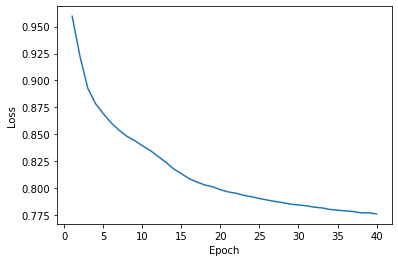

In [79]:
model = MLP(num_users, num_items, embed_dim, mlp_hidden_dims, single=True).to(device)
opt = torch.optim.Adam(model.parameters(), lr= 0.01)
train(model, opt, neg_sampler, 40)

In [83]:
train(model, opt, neg_sampler, 40)

  2%|▎         | 1/40 [00:16<10:43, 16.49s/it]

 loss: 0.7750572401389526


  5%|▌         | 2/40 [00:32<10:26, 16.48s/it]

 loss: 0.7750311066635359


  8%|▊         | 3/40 [00:50<10:22, 16.81s/it]

 loss: 0.774618065596609


 10%|█         | 4/40 [01:06<10:00, 16.68s/it]

 loss: 0.7737194687342914


 12%|█▎        | 5/40 [01:23<09:42, 16.66s/it]

 loss: 0.7728264086892258


 15%|█▌        | 6/40 [01:40<09:30, 16.78s/it]

 loss: 0.7722113034568044


 18%|█▊        | 7/40 [01:57<09:15, 16.84s/it]

 loss: 0.7723937581852462


 20%|██        | 8/40 [02:13<08:54, 16.71s/it]

 loss: 0.7716497552996437


 20%|██        | 8/40 [02:20<09:22, 17.57s/it]


KeyboardInterrupt: 

In [84]:
model.eval()

MLP(
  (user_emb): Embedding(6040, 32)
  (item_emb): Embedding(3706, 32)
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [85]:
model.save_pretrained('mlp.pt')

In [86]:
rec.get_similars(1, model, movie_info)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
33,34,Babe (1995),Children's|Comedy|Drama
360,364,"Lion King, The (1994)",Animation|Children's|Musical
584,588,Aladdin (1992),Animation|Children's|Comedy|Musical
1132,1148,"Wrong Trousers, The (1993)",Animation|Comedy
1245,1265,Groundhog Day (1993),Comedy|Romance
1595,1641,"Full Monty, The (1997)",Comedy
2252,2321,Pleasantville (1998),Comedy
2315,2384,Babe: Pig in the City (1998),Children's|Comedy
3184,3253,Wayne's World (1992),Comedy


In [87]:
rec.recommend(4, model, movie_info)

,movie_id,name,category
1204,1222,Full Metal Jacket (1987),Action|Drama|War
1267,1287,Ben-Hur (1959),Action|Adventure|Drama
1884,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
2875,2944,"Dirty Dozen, The (1967)",Action|War
2880,2949,Dr. No (1962),Action
2924,2993,Thunderball (1965),Action
2993,3062,"Longest Day, The (1962)",Action|Drama|War
3297,3366,Where Eagles Dare (1969),Action|Adventure|War
3585,3654,"Guns of Navarone, The (1961)",Action|Drama|War
3766,3836,Kelly's Heroes (1970),Action|Comedy|War


In [88]:
rec.metrics(model, test)

100%|██████████| 6040/6040 [00:20<00:00, 296.11it/s]


NDCG@10 = 0.3195, HR@10 = 0.5791390728476821


## Pretrain GMF

  5%|▌         | 1/20 [00:12<03:48, 12.00s/it]

 loss: 1.1099891532461872


 10%|█         | 2/20 [00:23<03:34, 11.94s/it]

 loss: 1.0959361015706794


 15%|█▌        | 3/20 [00:35<03:24, 12.00s/it]

 loss: 0.9831915630984871


 20%|██        | 4/20 [00:49<03:18, 12.40s/it]

 loss: 0.9357599060518244


 25%|██▌       | 5/20 [01:01<03:03, 12.24s/it]

 loss: 0.8477481590424704


 30%|███       | 6/20 [01:12<02:49, 12.10s/it]

 loss: 0.7877401164766443


 35%|███▌      | 7/20 [01:25<02:39, 12.24s/it]

 loss: 0.7511321225200697


 40%|████      | 8/20 [01:37<02:25, 12.12s/it]

 loss: 0.7272740605562527


 45%|████▌     | 9/20 [01:50<02:16, 12.44s/it]

 loss: 0.7108576063270058


 50%|█████     | 10/20 [02:02<02:02, 12.24s/it]

 loss: 0.698359217905237


 55%|█████▌    | 11/20 [02:14<01:49, 12.16s/it]

 loss: 0.6890120574423754


 60%|██████    | 12/20 [02:26<01:37, 12.23s/it]

 loss: 0.6814611594966707


 65%|██████▌   | 13/20 [02:38<01:25, 12.16s/it]

 loss: 0.6753686331020693


 70%|███████   | 14/20 [02:51<01:14, 12.38s/it]

 loss: 0.6703067998316458


 75%|███████▌  | 15/20 [03:03<01:01, 12.31s/it]

 loss: 0.6658060572481302


 80%|████████  | 16/20 [03:15<00:48, 12.19s/it]

 loss: 0.6627294649854379


 85%|████████▌ | 17/20 [03:27<00:36, 12.23s/it]

 loss: 0.6590631397327852


 90%|█████████ | 18/20 [03:39<00:24, 12.11s/it]

 loss: 0.6571192822115061


 95%|█████████▌| 19/20 [03:52<00:12, 12.31s/it]

 loss: 0.6544477640968641


100%|██████████| 20/20 [04:04<00:00, 12.24s/it]

 loss: 0.6524717454807152


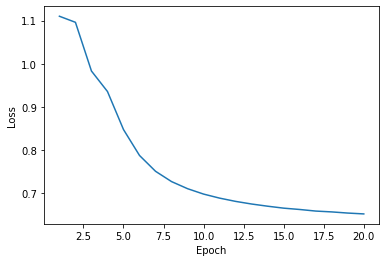

In [90]:
model = GMF(num_users, num_items, embed_dim=embed_dim, single=True).to(device)
opt = torch.optim.Adam(model.parameters(), lr = 0.005)
train(model, opt, neg_sampler, 20)

In [91]:
model.save_pretrained('gmf.pt')

In [92]:
rec.get_similars(1, model, movie_info)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
33,34,Babe (1995),Children's|Comedy|Drama
1245,1265,Groundhog Day (1993),Comedy|Romance
1595,1641,"Full Monty, The (1997)",Comedy
1854,1923,There's Something About Mary (1998),Comedy
2252,2321,Pleasantville (1998),Comedy
2255,2324,Life Is Beautiful (La Vita � bella) (1997),Comedy|Drama
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
2327,2396,Shakespeare in Love (1998),Comedy|Romance
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy


In [93]:
rec.get_history(4, movie_info)

,movie_id,name,category
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi
1023,1036,Die Hard (1988),Action|Thriller
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure
1183,1201,"Good, The Bad and The Ugly, The (1966)",Action|Western
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1196,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller


In [94]:
rec.recommend(4, model, movie_info)

,movie_id,name,category
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
847,858,"Godfather, The (1972)",Action|Crime|Drama
1048,1062,"Sunchaser, The (1996)",Drama
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1204,1222,Full Metal Jacket (1987),Action|Drama|War
1885,1954,Rocky (1976),Action|Drama
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
2261,2330,Hands on a Hard Body (1996),Documentary
2875,2944,"Dirty Dozen, The (1967)",Action|War
3634,3703,Mad Max 2 (a.k.a. The Road Warrior) (1981),Action|Sci-Fi


In [95]:
rec.metrics(model, test)

100%|██████████| 6040/6040 [00:18<00:00, 318.36it/s]


NDCG@10 = 0.3446, HR@10 = 0.6332781456953642


## Train NCF

  5%|▌         | 1/20 [00:19<06:03, 19.12s/it]

 loss: 0.6763538914654945


 10%|█         | 2/20 [00:39<05:50, 19.46s/it]

 loss: 0.6421511228494615


 15%|█▌        | 3/20 [00:59<05:32, 19.55s/it]

 loss: 0.63861198037341


 20%|██        | 4/20 [01:17<05:08, 19.28s/it]

 loss: 0.63654419555723


 25%|██▌       | 5/20 [01:38<04:53, 19.60s/it]

 loss: 0.6353516711572418


 30%|███       | 6/20 [01:57<04:32, 19.49s/it]

 loss: 0.6333735785634093


 35%|███▌      | 7/20 [02:16<04:12, 19.45s/it]

 loss: 0.6319165282588295


 40%|████      | 8/20 [02:37<03:56, 19.71s/it]

 loss: 0.6300895835908876


 45%|████▌     | 9/20 [02:55<03:33, 19.45s/it]

 loss: 0.6287076967997605


 50%|█████     | 10/20 [03:15<03:13, 19.39s/it]

 loss: 0.6278455198179436


 55%|█████▌    | 11/20 [03:35<02:55, 19.54s/it]

 loss: 0.6270043346282751


 60%|██████    | 12/20 [03:54<02:36, 19.54s/it]

 loss: 0.6256733338140434


 65%|██████▌   | 13/20 [04:13<02:15, 19.41s/it]

 loss: 0.6241974066386631


 70%|███████   | 14/20 [04:33<01:57, 19.62s/it]

 loss: 0.623169558024922


 75%|███████▌  | 15/20 [04:53<01:38, 19.63s/it]

 loss: 0.6232336498988768


 80%|████████  | 16/20 [05:12<01:17, 19.44s/it]

 loss: 0.6217412945232235


 85%|████████▌ | 17/20 [05:32<00:59, 19.67s/it]

 loss: 0.6215385005537931


 90%|█████████ | 18/20 [05:52<00:39, 19.64s/it]

 loss: 0.6203693425864073


 95%|█████████▌| 19/20 [06:11<00:19, 19.42s/it]

 loss: 0.6198300272072872


100%|██████████| 20/20 [06:31<00:00, 19.58s/it]

 loss: 0.6188480177880806


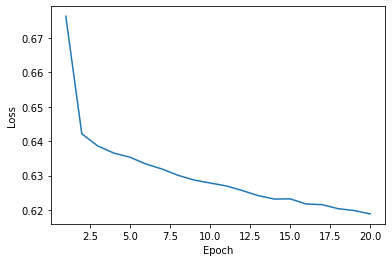

In [96]:
model = NCF(num_users=num_users, num_items=num_items, embed_dim=embed_dim, mlp_hidden_dims=mlp_hidden_dims)
model.load_pretrained('mlp.pt', 'gmf.pt')
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
train(model, opt, neg_sampler, 20)

In [97]:
model.eval()

NCF(
  (mlp): MLP(
    (user_emb): Embedding(6040, 32)
    (item_emb): Embedding(3706, 32)
    (layers): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
      (5): Linear(in_features=32, out_features=16, bias=True)
      (6): ReLU()
    )
  )
  (gmf): GMF(
    (user_emb): Embedding(6040, 32)
    (item_emb): Embedding(3706, 32)
  )
  (last_layer): Linear(in_features=48, out_features=1, bias=True)
)

In [98]:
rec = Recommender(user_item_csr, user2idx, idx2user, movie2idx, idx2movie)

In [99]:
rec.get_similars(1, model, movie_info)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
38,39,Clueless (1995),Comedy|Romance
353,357,Four Weddings and a Funeral (1994),Comedy|Romance
360,364,"Lion King, The (1994)",Animation|Children's|Musical
584,588,Aladdin (1992),Animation|Children's|Comedy|Musical
1245,1265,Groundhog Day (1993),Comedy|Romance
1595,1641,"Full Monty, The (1997)",Comedy
2252,2321,Pleasantville (1998),Comedy
2290,2359,Waking Ned Devine (1998),Comedy
3184,3253,Wayne's World (1992),Comedy


In [100]:
rec.recommend(4, model, movie_info)

,movie_id,name,category
847,858,"Godfather, The (1972)",Action|Crime|Drama
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1182,1200,Aliens (1986),Action|Sci-Fi|Thriller|War
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
1204,1222,Full Metal Jacket (1987),Action|Drama|War
1621,1667,Mad City (1997),Action|Drama
1885,1954,Rocky (1976),Action|Drama
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2875,2944,"Dirty Dozen, The (1967)",Action|War
3336,3405,"Night to Remember, A (1958)",Action|Drama


In [101]:
rec.metrics(model, test)

100%|██████████| 6040/6040 [00:21<00:00, 278.24it/s]


NDCG@10 = 0.3551, HR@10 = 0.6440397350993378
